Video FPS: 30
Total Frames: 854
Duration: 28.47 seconds
Saved frame 0 as extracted_frames\frame_00000.jpg
Saved frame 30 as extracted_frames\frame_00030.jpg
Saved frame 60 as extracted_frames\frame_00060.jpg
Saved frame 90 as extracted_frames\frame_00090.jpg
Saved frame 120 as extracted_frames\frame_00120.jpg
Saved frame 150 as extracted_frames\frame_00150.jpg
Saved frame 180 as extracted_frames\frame_00180.jpg
Saved frame 210 as extracted_frames\frame_00210.jpg
Saved frame 240 as extracted_frames\frame_00240.jpg
Saved frame 270 as extracted_frames\frame_00270.jpg
Saved frame 300 as extracted_frames\frame_00300.jpg
Saved frame 330 as extracted_frames\frame_00330.jpg
Saved frame 360 as extracted_frames\frame_00360.jpg
Saved frame 390 as extracted_frames\frame_00390.jpg
Saved frame 420 as extracted_frames\frame_00420.jpg
Saved frame 450 as extracted_frames\frame_00450.jpg
Saved frame 480 as extracted_frames\frame_00480.jpg
Saved frame 510 as extracted_frames\frame_00510.jpg
Saved frame 5

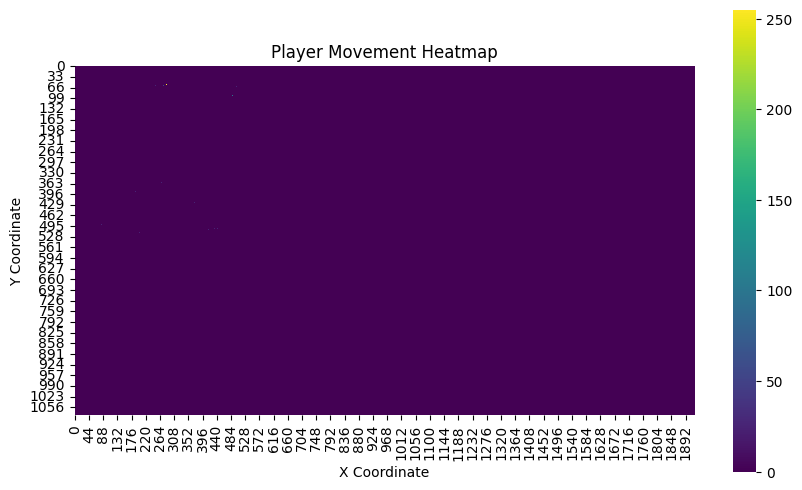

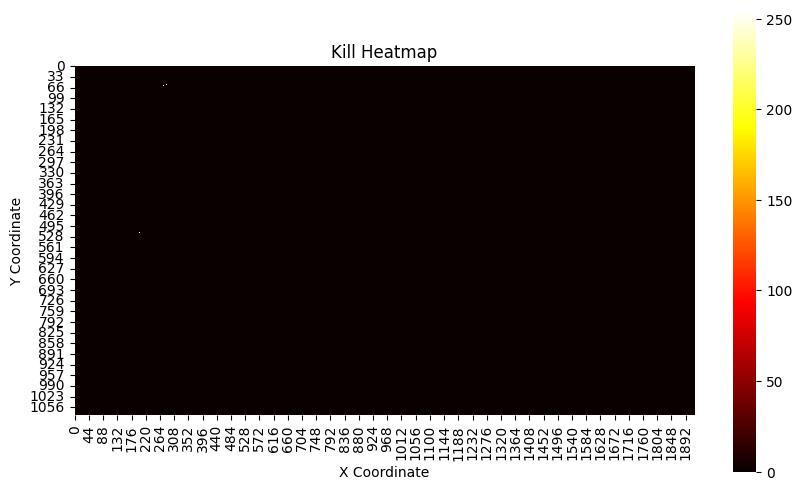

In [9]:
import cv2
import os
import numpy as np
import pytesseract
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

# Input video file path
video_path = r"D:\Study\Mined\Val1.mp4"

# Output directory to save frames and heatmaps
output_dir = "extracted_frames"
os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
    exit()

# Get video properties
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames
duration = total_frames / frame_rate  # Duration in seconds

print(f"Video FPS: {frame_rate}")
print(f"Total Frames: {total_frames}")
print(f"Duration: {duration:.2f} seconds")

# Set the interval for frame extraction (e.g., extract every Nth frame)
frame_interval = 30  # Extract 1 frame per second for a 30 FPS video
frame_count = 0
saved_frame_count = 0

# Variables to track kills, deaths, assists, and headshots
total_kills = 0
total_deaths = 0
total_assists = 0
total_headshots = 0

# List to store timestamps of detected kills, deaths, assists, and headshots (to prevent recounting)
detected_kills = []
detected_deaths = []
detected_assists = []
detected_headshots = []

# Set to store unique gun names
gun_names = set()

# Cooldown period (in frames) to ignore the same event
cooldown_frames = 5 * frame_rate  # 5 seconds cooldown

# List of known gun names in Valorant (add more as needed)
KNOWN_GUN_NAMES = {"Vandal", "Phantom", "Operator", "Sheriff", "Spectre", "Ghost", "Judge", "Odin", "Ares", "Bulldog"}

# Heatmaps to track player movement and kill locations
movement_heatmap = np.zeros((1080, 1920), dtype=np.uint32)  # Adjust based on video resolution
kill_heatmap = np.zeros((1080, 1920), dtype=np.uint32)  # Adjust based on video resolution

# Function to detect kills based on the color of the kill feed popup
def detect_kills_by_color(frame, current_frame_number):
    global total_kills, detected_kills

    # Crop the kill feed region (top-right corner of the screen)
    kill_feed_region = frame[75:300, 1400:1920]  # Adjust coordinates based on your video resolution

    # Check if the cropped region is valid
    if kill_feed_region.size == 0:
        print("Warning: Invalid kill feed region. Check cropping coordinates.")
        return

    # Convert the region to HSV color space for better color detection
    hsv = cv2.cvtColor(kill_feed_region, cv2.COLOR_BGR2HSV)

    # Define color ranges for kill feed popups
    lower_red = np.array([0, 120, 70])  # Lower bound of red in HSV
    upper_red = np.array([10, 255, 255])  # Upper bound of red in HSV

    # Create a mask to isolate red-colored regions
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of kill popups
    kill_count = 0
    for contour in contours:
        # Filter out small contours (noise)
        if cv2.contourArea(contour) > 50:  # Adjust the threshold as needed
            # Check if this kill event is already detected within the cooldown period
            is_new_kill = True
            for kill in detected_kills:
                if abs(current_frame_number - kill) <= cooldown_frames:
                    is_new_kill = False
                    break

            # If it's a new kill, add it to the list and increment the kill count
            if is_new_kill:
                detected_kills.append(current_frame_number)
                kill_count += 1

    # Update the total kill count
    total_kills += kill_count

    # Optional: Display the mask and kill feed region for debugging
    cv2.imshow("Kill Feed Mask", mask)
    cv2.imshow("Kill Feed Region", kill_feed_region)
    cv2.waitKey(1)

# Function to detect deaths based on the color of the kill feed popup
def detect_deaths_by_color(frame, current_frame_number):
    global total_deaths, detected_deaths

    # Crop the kill feed region (top-right corner of the screen)
    # Adjust coordinates to tightly focus on the victim's name in the kill feed
    death_feed_region = frame[75:500, 1700:1920]  # Narrowed region to avoid sky

    # Check if the cropped region is valid
    if death_feed_region.size == 0:
        print("Warning: Invalid kill feed region. Check cropping coordinates.")
        return

    # Convert the region to HSV color space for better color detection
    hsv = cv2.cvtColor(death_feed_region, cv2.COLOR_BGR2HSV)

    # Define color ranges for the victim's name in the kill feed
    # Adjust these values based on the specific color of the victim's name in your video
    lower_blue = np.array([100, 120, 70])  # Lower bound of blue in HSV
    upper_blue = np.array([130, 255, 255])  # Upper bound of blue in HSV

    # Create a mask to isolate the victim's name color
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Use morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Fill small holes

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of death popups
    death_count = 0
    for contour in contours:
        # Filter out small contours (noise)
        if cv2.contourArea(contour) > 50:  # Adjust the threshold as needed
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Additional filtering based on aspect ratio and position
            aspect_ratio = w / h
            if 2 < aspect_ratio < 10:  # Victim's name is usually wider than tall
                # Check if this death event is already detected within the cooldown period
                is_new_death = True
                for death in detected_deaths:
                    if abs(current_frame_number - death) <= cooldown_frames:
                        is_new_death = False
                        break

                # If it's a new death, add it to the list and increment the death count
                if is_new_death:
                    detected_deaths.append(current_frame_number)
                    death_count += 1

                    # Optional: Draw the bounding box on the frame for debugging
                    cv2.rectangle(death_feed_region, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Update the total death count
    total_deaths += death_count

    # Optional: Display the mask and kill feed region for debugging
    cv2.imshow("Death Mask", mask)
    cv2.imshow("Death Feed Region", death_feed_region)
    cv2.waitKey(1)

# Function to detect headshots based on the color of the headshot indicator
def detect_headshots_by_color(frame, current_frame_number):
    global total_headshots, detected_headshots

    # Crop the headshot region (bottom center of the screen)
    headshot_region = frame[760:960, 830:1090]  # Adjust coordinates based on your video resolution

    # Check if the cropped region is valid
    if headshot_region.size == 0:
        print("Warning: Invalid headshot region. Check cropping coordinates.")
        return

    # Convert the region to HSV color space for better color detection
    hsv = cv2.cvtColor(headshot_region, cv2.COLOR_BGR2HSV)

    # Define color ranges for headshot indicators (adjust these ranges as needed)
    lower_blue = np.array([100, 120, 70])  # Lower bound of blue in HSV
    upper_blue = np.array([130, 255, 255])  # Upper bound of blue in HSV

    # Create a mask to isolate blue-colored regions
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of headshot indicators
    headshot_count = 0
    for contour in contours:
        # Filter out small contours (noise)
        if cv2.contourArea(contour) > 50:  # Adjust the threshold as needed
            # Check if this headshot event is already detected within the cooldown period
            is_new_headshot = True
            for headshot in detected_headshots:
                if abs(current_frame_number - headshot) <= cooldown_frames:
                    is_new_headshot = False
                    break

            # If it's a new headshot, add it to the list and increment the headshot count
            if is_new_headshot:
                detected_headshots.append(current_frame_number)
                headshot_count += 1

    # Update the total headshot count
    total_headshots += headshot_count

    # Optional: Display the mask and headshot region for debugging
    cv2.imshow("Headshot Mask", mask)
    cv2.imshow("Headshot Region", headshot_region)
    cv2.waitKey(1)

# Function to analyze gun name using OCR
def analyze_gun_name(frame):
    # Crop the gun name region (adjust coordinates based on your HUD)
    gun_name_region = frame[720:920, 1500:1900]  # Example: y_start=720, y_end=920, x_start=1500, x_end=1900

    # Check if the cropped region is valid
    if gun_name_region.size == 0:
        return None

    # Preprocess the region for better OCR accuracy
    gray = cv2.cvtColor(gun_name_region, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)  # Invert colors for better text extraction
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)  # Remove noise

    # Use Tesseract OCR to extract text
    gun_name = pytesseract.image_to_string(thresh, config='--psm 7').strip()

    # Validate the gun name against known gun names
    if gun_name in KNOWN_GUN_NAMES:
        return gun_name
    else:
        return None

# Function to update the heatmap based on player movement
def update_heatmap(frame):
    global movement_heatmap, kill_heatmap

    # Crop the minimap region (adjust coordinates based on your HUD)
    minimap_region = frame[20:500, 15:480]  # Example: y_start=50, y_end=250, x_start=50, x_end=250

    # Check if the cropped region is valid
    if minimap_region.size == 0:
        return

    # Convert the minimap region to grayscale
    gray = cv2.cvtColor(minimap_region, cv2.COLOR_BGR2GRAY)

    # Threshold the image to isolate player movement
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Update the movement heatmap based on player position
    for contour in contours:
        if cv2.contourArea(contour) > 10:  # Filter out small contours
            # Get the centroid of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                movement_heatmap[cy + 50, cx + 50] += 1  # Adjust coordinates to match the full frame

    # If a kill is detected, update the kill heatmap
    if frame_count in detected_kills:
        for contour in contours:
            if cv2.contourArea(contour) > 10:  # Filter out small contours
                # Get the centroid of the contour
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    kill_heatmap[cy + 50, cx + 50] += 1  # Adjust coordinates to match the full frame

    # Optional: Display the minimap region for debugging
    cv2.imshow("Minimap Region", minimap_region)
    cv2.waitKey(1)

# Function to generate and display the heatmap using Seaborn
def generate_heatmap():
    global movement_heatmap, kill_heatmap

    # Normalize the heatmaps for visualization
    movement_heatmap_normalized = cv2.normalize(movement_heatmap.astype(np.float32), None, 0, 255, cv2.NORM_MINMAX)
    kill_heatmap_normalized = cv2.normalize(kill_heatmap.astype(np.float32), None, 0, 255, cv2.NORM_MINMAX)

    # Plot the movement heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(movement_heatmap_normalized, cmap="viridis", cbar=True, square=True)
    plt.title("Player Movement Heatmap")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

    # Plot the kill heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(kill_heatmap_normalized, cmap="hot", cbar=True, square=True)
    plt.title("Kill Heatmap")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

while True:
    ret, frame = cap.read()  # Read the next frame
    if not ret:
        break  # Exit the loop if no more frames are available

    # Save the frame at the specified interval
    if frame_count % frame_interval == 0:
        frame_filename = os.path.join(output_dir, f"frame_{frame_count:05d}.jpg")
        cv2.imwrite(frame_filename, frame)
        saved_frame_count += 1
        print(f"Saved frame {frame_count} as {frame_filename}")

        # Detect kills, deaths, and headshots in the current frame
        detect_kills_by_color(frame, frame_count)
        detect_deaths_by_color(frame, frame_count)
        detect_headshots_by_color(frame, frame_count)

        # Analyze gun name
        gun_name = analyze_gun_name(frame)
        if gun_name:
            gun_names.add(gun_name)
            print(f"Detected Gun: {gun_name}")

        # Update the heatmap based on player movement
        update_heatmap(frame)

    frame_count += 1

# Release the video capture object
cap.release()
cv2.destroyAllWindows()

# Calculate K/D ratio
kd_ratio = total_kills / total_deaths if total_deaths > 0 else total_kills

# Print the results
print(f"Extraction complete! Saved {saved_frame_count} frames to {output_dir}.")
print(f"Total Kills Detected: {total_kills}")
print(f"Total Deaths Detected: {total_deaths}")
print(f"Total Headshots Detected: {total_headshots}")
print(f"Headshot Percentage: {(total_headshots / total_kills * 100):.2f}%" if total_kills > 0 else "No kills detected.")
print(f"K/D Ratio: {(kd_ratio)}")

# Generate and display the heatmap
generate_heatmap()